In [1]:
from lab_scripts.utils import utils
utils.change_directory_to_repo()
utils.set_deafult_seed()

from lab_scripts.data import dataloader
from lab_scripts.data.integration import processor

import numpy as np
import pandas as pd
import anndata as pd
import torch
from torch.utils.data import DataLoader
from lab_scripts.models.x_autoencoder import model as x_autoencoder
import pytorch_lightning as pl

Global seed set to 228


In [2]:
dataset = dataloader.load_data('mp/official/gex_to_adt')
first_mod = utils.get_mod(dataset["train_mod1"])
second_mod = utils.get_mod(dataset["train_mod2"])
task_type = utils.get_task_type(first_mod, second_mod)

In [3]:
first_mod_config = {
    'use_normalized': True,
    'scale': True
}
first_processor = processor.Processor(first_mod_config, first_mod)
train_first_X, _ = first_processor.fit_transform(dataset["train_mod1"])
test_first_X, first_inverse = first_processor.transform(dataset["test_mod1"])


In [4]:
second_mod_config = {
    'use_normalized': True,
    'scale': True
}
second_processor = processor.Processor(second_mod_config, second_mod)
train_second_X, _ = second_processor.fit_transform(dataset["train_mod2"])
test_second_X, second_inverse = second_processor.transform(dataset["test_mod2"])

In [5]:
def get_batch_idx(dataset):
    mapping = {item:i for (i, item) in enumerate(dataset.obs['batch'].cat.remove_unused_categories().unique())}
    batch_idx = dataset.obs['batch'].cat.remove_unused_categories().apply(lambda x: mapping[x])
    batch_idx = batch_idx.to_numpy()
    # np.random.shuffle(batch_idx)
    batch_idx = torch.tensor(batch_idx)
    return batch_idx

In [6]:
train_batch_idx = get_batch_idx(dataset['train_mod1'])
test_batch_idx = get_batch_idx(dataset['test_mod1'])

In [28]:
model_config = {
    'first_dims': [2000, 700, 500],
    'first_bn': -1,
    'second_dims': [100, 100],
    'latent_dim': 300,
    'activation': 'leaky_relu',
    'lr': 0.001,
    'batch_size': 128,
    'use_mmd_loss': True,
    'mmd_lambda': 1.,
}

In [29]:
model_config["first_dims"].insert(0, train_first_X.shape[1])
model_config["second_dims"].insert(0, train_second_X.shape[1])

In [30]:
train_dataset = processor.TwoOmicsDataset(train_first_X, train_second_X, train_batch_idx)
train_dataloader = DataLoader(
    train_dataset, batch_size=model_config["batch_size"], shuffle=True, pin_memory=True, num_workers=1,
)
test_dataset = processor.TwoOmicsDataset(test_first_X.cuda(), test_second_X.cuda(), test_batch_idx)
test_dataloader = DataLoader(test_dataset, batch_size=model_config["batch_size"])

In [31]:
validation_callback = x_autoencoder.TargetCallback(
    test_dataloader=test_dataloader,
    first_inverse=first_inverse,
    first_true_target=dataset["test_mod1"],
    second_inverse=second_inverse,
    second_true_target=dataset["test_mod2"],
)

In [32]:
model = x_autoencoder.X_autoencoder(model_config)
trainer = pl.Trainer(
    gpus=1,
    max_epochs=5000,
    callbacks=[
        validation_callback,
    ],
    deterministic=True,
    checkpoint_callback=False,
    gradient_clip_val=2.0,
)

INFO:x_autoencoder:First encoder dims: [13953, 2000, 700, 500, 300]
INFO:x_autoencoder:Second encoder dims: [134, 100, 100, 300]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [33]:
trainer.fit(model, train_dataloaders=train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | loss           | MSELoss | 0     
1 | first_encoder  | Encoder | 29.8 M
2 | first_decoder  | Decoder | 29.8 M
3 | second_encoder | Encoder | 53.9 K
4 | second_decoder | Decoder | 53.7 K
-------------------------------------------
59.7 M    Trainable params
0         Non-trainable params
59.7 M    Total params
238.961   Total estimated model params size (MB)
/home/simon/miniconda3/envs/nips/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/228 [00:00<00:00, 2033.11it/s]  

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 1:   0%|          | 0/228 [00:00<00:00, 1238.35it/s, loss=3.71, v_num=3, mmd=0.0494] 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 2:   0%|          | 0/228 [00:00<00:00, 1516.38it/s, loss=3.45, v_num=3, mmd=0.0792, true_1_to_2=0.827, true_2_to_1=0.318] 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 3:   0%|          | 0/228 [00:00<00:00, 1428.58it/s, loss=3.33, v_num=3, mmd=0.0515, true_1_to_2=0.700, true_2_to_1=0.312] 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 4:   0%|          | 0/228 [00:00<00:00, 1145.98it/s, loss=3.22, v_num=3, mmd=0.0358, true_1_to_2=0.655, true_2_to_1=0.304] 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 5:   0%|          | 0/228 [00:00<00:00, 1693.98it/s, loss=3.16, v_num=3, mmd=0.0342, true_1_to_2=0.616, true_2_to_1=0.304] 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 6:   0%|          | 0/228 [00:00<00:00, 1363.56it/s, loss=3.1, v_num=3, mmd=0.0188, true_1_to_2=0.617, true_2_to_1=0.303] 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 6:  12%|█▏        | 28/228 [00:02<00:18, 11.08it/s, loss=8.11, v_num=3, mmd=0.0279, true_1_to_2=0.615, true_2_to_1=0.303]

/home/simon/miniconda3/envs/nips/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1046: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [34]:
latent_result = []
for batch in train_dataloader:
    inputs, _ = batch
    first, second = inputs
    result = model(first.cpu(), second.cpu())
    latent_result.append(result['first_latent'])


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 11:  17%|█▋        | 38/228 [09:34<46:37, 14.72s/it, loss=2.44, v_num=2, true_1_to_2=0.422, true_2_to_1=0.293]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8a313c3550>
Traceback (most recent call last):
  File "/home/simon/miniconda3/envs/nips/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/simon/miniconda3/envs/nips/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/simon/miniconda3/envs/nips/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


In [35]:
latent_result = torch.cat(latent_result, dim=0).cpu().detach()

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embeddings = pca.fit_transform(latent_result.numpy())

<AxesSubplot:>

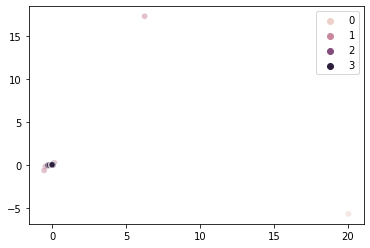

In [37]:
import seaborn as sns
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=train_batch_idx, alpha=0.5)

In [20]:
test_batch_idx

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
latent_result.shape

torch.Size([1000, 300])